In [1]:
#!/usr/bin/python3

from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
import os
import sys
import pandas as pd

from smartsim import Experiment
from smartredis import Client
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 200

import torch
import torch.nn as nn
import numpy as np
import io
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler

class MLP(nn.Module):
    def __init__(self, num_layers, layer_width, input_size, output_size, activation_fn):
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, layer_width))
        layers.append(activation_fn)

        for _ in range(num_layers - 2):
            layers.append(nn.Linear(layer_width, layer_width))
            layers.append(activation_fn)

        layers.append(nn.Linear(layer_width, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
def sort_tensors_by_names(tensors, tensor_names):
    # Pair each tensor with its name and sort by the name
    pairs = sorted(zip(tensor_names, tensors))

    # Extract the sorted tensors
    tensor_names_sorted, tensors_sorted = zip(*pairs)

    # Convert back to list if needed
    tensor_names_sorted = list(tensor_names_sorted)
    tensors_sorted = list(tensors_sorted)

    return tensors_sorted, tensor_names_sorted

def visualization_points(n_points):

    domain_min = [-3, -3, 0]
    domain_max = [3, 3, 0]
    radius = 1

    # Generate grid of points
    x = np.linspace(domain_min[0], domain_max[0], n_points)
    y = np.linspace(domain_min[1], domain_max[1], n_points)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.column_stack((xx.ravel(), yy.ravel(), np.zeros(n_points**2)))

    # Filter out points within the circle
    norm = np.linalg.norm(grid_points[:, :2], axis=1)
    visualization_points = grid_points[norm > radius]

    return visualization_points


exp = Experiment("mesh-motion", launcher="local")

db = exp.create_database(port=8000,       # database port
                         interface="lo")  # network interface to use
exp.start(db)

# Connect the python client to the smartredis database
client = Client(address=db.get_address()[0], cluster=False)

num_mpi_ranks = 4

of_rs = exp.create_run_settings(exe="moveDynamicMesh", exe_args="-case spinningDisk -parallel", 
                                run_command="mpirun", 
                                run_args={"np": f"{num_mpi_ranks}"})

of_model = exp.create_model(name="of_model", run_settings=of_rs)

# List installed ML backends
from smartsim._core.utils.helpers import installed_redisai_backends
print(installed_redisai_backends())

SmartRedis Library@07-59-32:WARNING: Environment variable SR_LOG_FILE is not set. Defaulting to stdout
SmartRedis Library@07-59-32:WARNING: Environment variable SR_LOG_LEVEL is not set. Defaulting to INFO
['tensorflow', 'torch', 'onnxruntime']


Time step 1
Saving model MLP
End time not reached.
Time step 2
Saving model MLP
End time not reached.
Time step 3
Saving model MLP
End time reached.
07:59:39 argo SmartSim[60607] INFO Stopping model orchestrator_0 with job name orchestrator_0-CW14KB4F667L


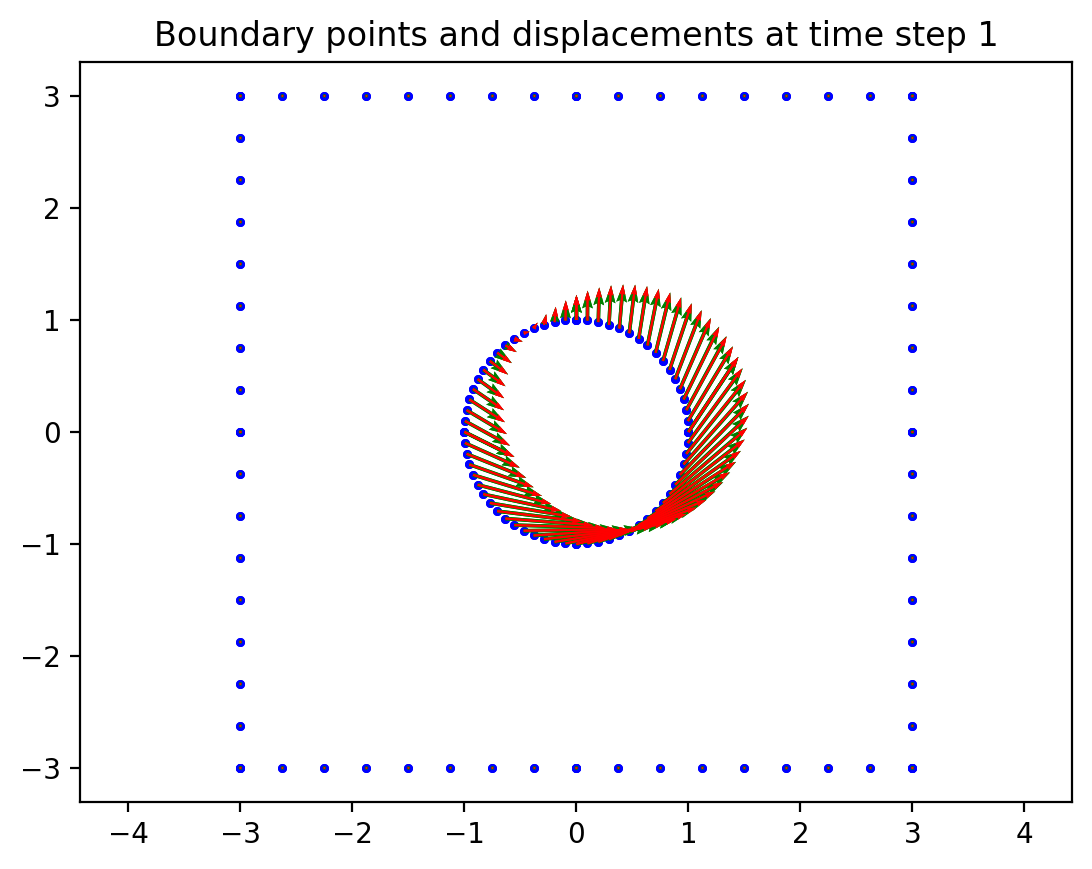

07:59:40 argo SmartSim[60607] INFO of_model(60795): Completed


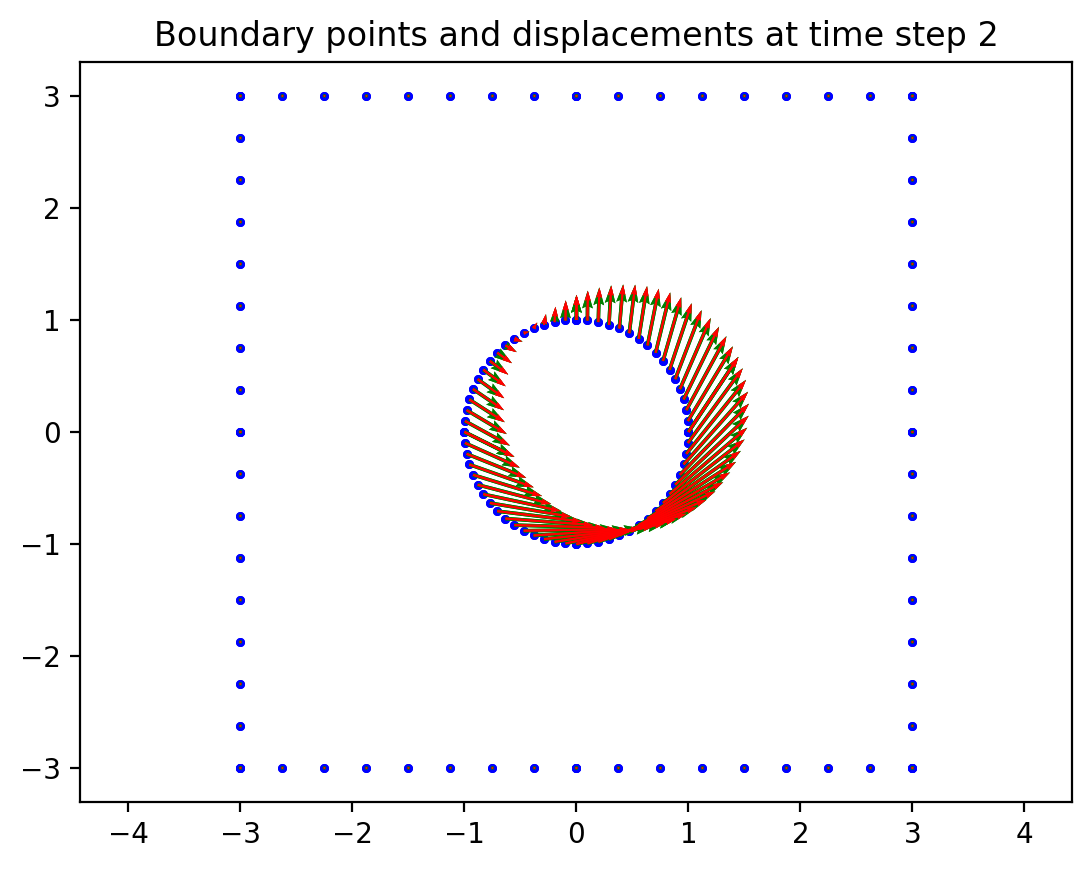

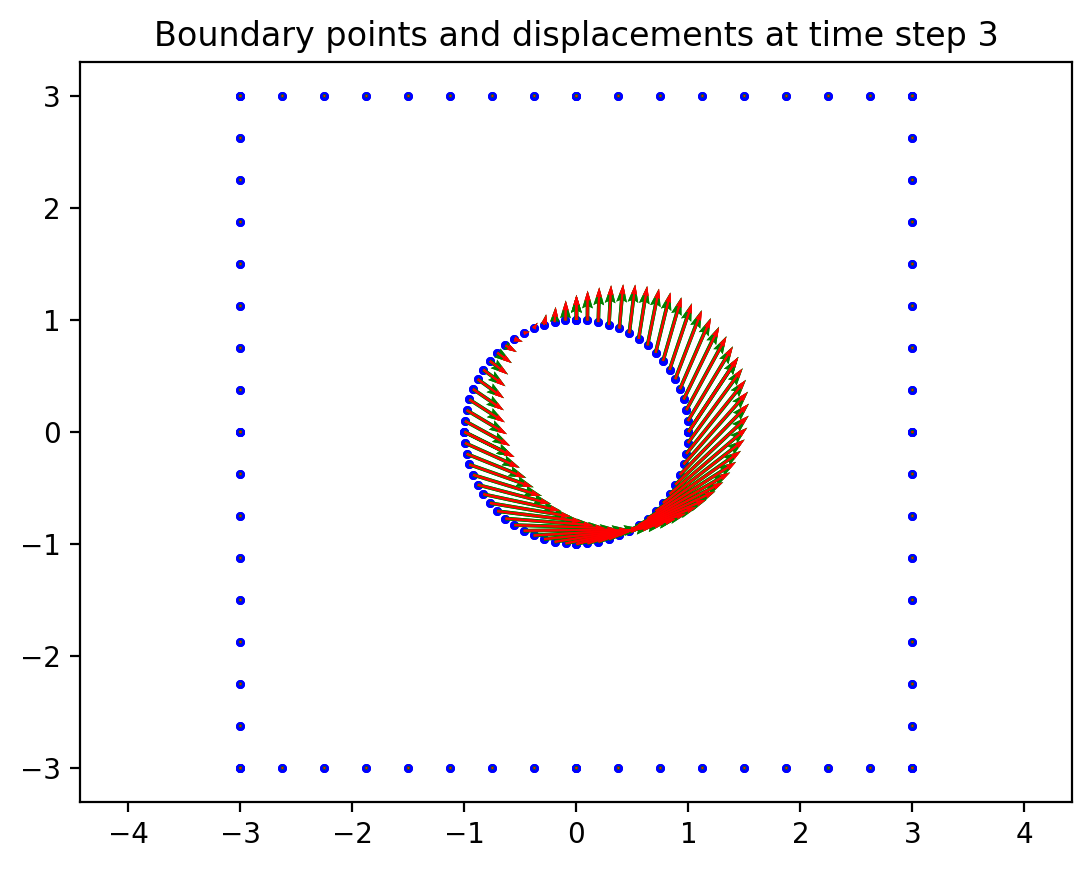

<Figure size 1280x960 with 0 Axes>

In [2]:
try:
    # Run the experiment
    exp.start(of_model, block=False)
    
    # Make sure all datasets are avaialble in the smartredis database.
    local_time_index = 1
    while True:
        
        print (f"Time step {local_time_index}")
          
        # Fetch datasets from SmartRedis
        dataset_list_length = local_time_index * num_mpi_ranks
        # - Poll until the points datasets are written by OpenFOAM
        # print (f"dataset_list_length {dataset_list_length}") # Debug info
        points_updated = client.poll_list_length("pointsDatasetList", 
                                                 local_time_index * num_mpi_ranks, 10, 1000);
        if (not points_updated):
            raise ValueError("Points dataset list not updated.")
            
        # - Poll until the displacements datasets are written by OpenFOAM
        # print (f"dataset_list_length {dataset_list_length}") # Debug info
        displacements_updated = client.poll_list_length("displacementsDatasetList", 
                                                        local_time_index * num_mpi_ranks, 10, 1000);
        if (not displacements_updated):
            raise ValueError("Displacements dataset list not updated.")
            
        # - Get the points and displacements datasets from SmartRedis
        points_datasets = client.get_datasets_from_list("pointsDatasetList");  
        displacements_datasets = client.get_datasets_from_list("displacementsDatasetList");
      
        # - Use only the datasets from this time step
        points_datasets = points_datasets[-num_mpi_ranks:]        
        displacements_datasets = displacements_datasets[-num_mpi_ranks:]
        
        # - Agglomerate all tensors from points and displacements datasets: 
        #   sort tensors by their names to ensure matching patches of same MPI ranks
        points = []
        points_names = []
        displacements = []
        displacements_names = []
        
        for points_dset, displs_dset in zip(points_datasets, displacements_datasets):
            points_tensor_names = points_dset.get_tensor_names()
            displs_tensor_names = displs_dset.get_tensor_names()
            for points_name,displs_name in zip(points_tensor_names,displs_tensor_names):
                patch_points = points_dset.get_tensor(points_name)
                points.append(patch_points)
                points_names.append(points_name)

                patch_displs = displs_dset.get_tensor(displs_name)
                displacements.append(patch_displs)
                displacements_names.append(displs_name)
                
        points, points_names = sort_tensors_by_names(points, points_names)
        displacements, displacements_names = sort_tensors_by_names(displacements, displacements_names)
        
        # Debug output for MPI rank matching 
#         print(points_names)
#         print(displacements_names)
        
        # - Reshape points and displacements into [N_POINTS,SPATIAL_DIMENSION] tensors
        #   This basically agglomerates data from OpenFOAM boundary patches into a list
        #   of boundary points (unstructured) and a list of respective point displacements. 
        points = torch.from_numpy(np.vstack(points)).float()
        displacements = torch.from_numpy(np.vstack(displacements)).float()
        
        # Visualize domain points and displacements     
        points_np = points.detach().numpy()
        displ_np = displacements.detach().numpy()

        plt.axis('equal')
        plt.title(f"Boundary points and displacements at time step {local_time_index}")
        plt.scatter(points_np[:, 0], points_np[:, 1], color='blue', s=5)
        plt.quiver(points_np[:, 0], points_np[:, 1], 
                   displ_np[:, 0], displ_np[:, 1], color='green')        

        
        # TODO(TM): hardcoded x,y coordinates, make the OF client store polymesh::solutionD
        #           and use solutionD non-zero values for sampling vector coordinates. 
        points = points[:, :2]
        displacements = displacements[:, :2]

        # Split training and validation data
        points_train, points_val, displ_train, displ_val = train_test_split(points, displacements, 
                                                                            test_size=0.2, random_state=42)

        # Fit the scaler on the training data
        target_scaler = MinMaxScaler().fit(displ_train.numpy()) 
        
        # Transform the training and validation data
        displ_train = torch.from_numpy(target_scaler.transform(displ_train.numpy())).float()
        displ_val = torch.from_numpy(target_scaler.transform(displ_val.numpy())).float()

        # Initialize the model
        model = MLP(num_layers=5, layer_width=20, input_size=2, output_size=2, activation_fn=torch.nn.Tanh())

        # PYTORCH Training Loop
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        loss_func = nn.MSELoss()
        epochs = 500
        mean_mag_displ = torch.mean(torch.norm(displ_train, dim=1))
        for epoch in range(epochs):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass on the training data
            displ_pred = model(points_train)

            # Compute loss on the training data
            loss_train = loss_func(displ_pred, displ_train)

            # Backward pass and optimization
            loss_train.backward()
            optimizer.step()

            # Forward pass on the validation data, with torch.no_grad() for efficiency
            with torch.no_grad():
                displ_pred_val = model(points_val)
                loss_val = loss_func(displ_pred_val, displ_val)
                rmse_loss_val = torch.sqrt(loss_val)
                # TODO(TM): log training progress somewhere
#                 print (f'Validation loss RMSE : {rmse_loss_val}, mean displacement magnitude {mean_mag_displ}')
#                 print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}')
    
    
        # Visualize predicted displacements 
        plt.axis('equal')
        displ_pred = model.forward(points)
        # Inverse transform the predictions
        displ_pred_np = torch.from_numpy(target_scaler.inverse_transform(displ_pred.detach().numpy())).float()
        plt.quiver(points_np[:, 0], points_np[:, 1], 
                   displ_pred_np[:, 0], displ_pred_np[:, 1], color='red', width=0.002)  
        plt.figure()
        
        # Visualize structured mesh points and displacements
#         plt.figure()
#         plt.axis('equal')
#         points_struct = torch.tensor(generate_struct_points(40)[:,:2]).float()
#         displ_struct = model.forward(points_struct)
#         displ_struct_np = torch.from_numpy(target_scaler.inverse_transform(displ_struct.detach().numpy())).float()
#         points_struct_np = points_struct.detach().numpy()
#         plt.quiver(points_struct_np[:, 0], points_struct_np[:, 1], 
#                    displ_struct_np[:, 0], displ_struct_np[:, 1], color='black', width=0.002)
        
        
        # Update the model in smartredis
        client.put_tensor("model_updated", np.array([0.]))
        
        #         # Store the model into SmartRedis
        # Prepare a sample input
        example_forward_input = torch.rand(2)
        # Convert the PyTorch model to TorchScript
        model_script = torch.jit.trace(model, example_forward_input)
        # Save the TorchScript model to a buffer
        model_buffer = io.BytesIO()
        torch.jit.save(model_script, model_buffer)
        # Set the model in the SmartRedis database
        print("Saving model MLP")
        client.set_model("MLP", model_buffer.getvalue(), "TORCH", "CPU")
    
        # Update time index and end loop if OpenFOAM simulation ended
        local_time_index = local_time_index + 1
        if client.poll_key("end_time_index", 10, 100):
            print ("End time reached.")
            break
        else:
            print ("End time not reached.")
    
    
except Exception as e:
    print("Caught an exception: ", str(e))
    
finally:
    exp.stop(db)